### CIFAR10
* CIFAR10 is another dataset with a long history in computer vision and machine
learning. Like MNIST, it is a common benchmark that various methods are tested
against. CIFAR10 is a set of 60,000 color images of size 32×32 pixels, each belonging
to one of ten categories: airplane, automobile, bird, cat, deer, dog, frog, horse, ship,
and truck.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import _pickle as cPickle

/home/jupyter/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jupyter/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jupyter/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jupyter/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
tf.keras.datasets.cifar10.load_data()

((array([[[[ 59,  62,  63],
           [ 43,  46,  45],
           [ 50,  48,  43],
           ...,
           [158, 132, 108],
           [152, 125, 102],
           [148, 124, 103]],
  
          [[ 16,  20,  20],
           [  0,   0,   0],
           [ 18,   8,   0],
           ...,
           [123,  88,  55],
           [119,  83,  50],
           [122,  87,  57]],
  
          [[ 25,  24,  21],
           [ 16,   7,   0],
           [ 49,  27,   8],
           ...,
           [118,  84,  50],
           [120,  84,  50],
           [109,  73,  42]],
  
          ...,
  
          [[208, 170,  96],
           [201, 153,  34],
           [198, 161,  26],
           ...,
           [160, 133,  70],
           [ 56,  31,   7],
           [ 53,  34,  20]],
  
          [[180, 139,  96],
           [173, 123,  42],
           [186, 144,  30],
           ...,
           [184, 148,  94],
           [ 97,  62,  34],
           [ 83,  53,  34]],
  
          [[177, 144, 116],
           [16

In [3]:
DATA_PATH = '/home/jupyter/.keras/datasets/cifar-10-batches-py/'

In [4]:
def unpickle(file):
    with open(os.path.join(DATA_PATH, file), 'rb') as fo:
        dict = cPickle.load(fo, encoding='latin1')
    return dict

def one_hot(vec, vals=10):
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [7]:
class CifarLoader(object):
    def __init__(self, source_files):
        self._source = source_files
        self._i = 0
        self.images = None
        self.labels = None
    
    
    def load(self):
        data = [unpickle(f) for f in self._source]
        images = np.vstack([d["data"] for d in data])
        n = len(images)
        self.images = images.reshape(n, 3, 32, 32)\
                .transpose(0, 2, 3, 1).astype(float) / 255
        self.labels = one_hot(np.hstack([d["labels"] for d in data]) , 10)
        return self

    
    def next_batch(self, batch_size):
        x, y =  self.images[self._i:self._i + batch_size], \
        self.labels[self._i:self._i + batch_size]
        self._i = (self._i + batch_size) % len(self.images)
        return x, y
    
    def random_batch(self, batch_size):
        n = len(self.images)
        ix = np.random.choice(n, batch_size)
        return self.images[ix], self.labels[ix]

In [8]:
class CifarDataManager(object):
    def __init__(self):
        self.train = CifarLoader(["data_batch_{}".format(i) for i in range(1, 6)]).load()
        self.test = CifarLoader(["test_batch"]).load()
    
def display_cifar(images, size):
    n = len(images)
    plt.figure()
    plt.gca().set_axis_off()
    im = np.vstack([np.hstack([images[np.random.choice(n)] for i in range(size)]) 
                       for i in range(size)])
    plt.imshow(im)
    plt.show()

Number of train images: 50000
Number of train labels: 50000
Number of test images: 10000
Number of test labels: 10000


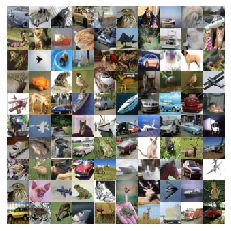

In [9]:
d = CifarDataManager()
print("Number of train images: {}".format(len(d.train.images)))
print("Number of train labels: {}".format(len(d.train.labels)))
print("Number of test images: {}".format(len(d.test.images)))
print("Number of test labels: {}".format(len(d.test.labels)))
images = d.train.images
display_cifar(images, 10)

In [10]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                         strides=[1, 2, 2, 1], padding='SAME')

def conv_layer(input, shape):
    W = weight_variable(shape)
    b = bias_variable([shape[3]])
    return tf.nn.relu(conv2d(input, W) + b)

def full_layer(input, size):
    in_size = int(input.get_shape()[1])
    W = weight_variable([in_size, size])
    b = bias_variable([size])
    return tf.matmul(input, W) + b

### Simple CIFAR10 Models

In [11]:
cifar = CifarDataManager()

x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

In [12]:
conv1 = conv_layer(x, shape=[5, 5, 3, 32])
conv1_pool = max_pool_2x2(conv1)

conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)

conv3 = conv_layer(conv2_pool, shape=[5, 5, 64, 128])
conv3_pool = max_pool_2x2(conv3)
conv3_flat = tf.reshape(conv3_pool, [-1, 4 * 4 * 128])
conv3_drop = tf.nn.dropout(conv3_flat, keep_prob=keep_prob)

full_1 = tf.nn.relu(full_layer(conv3_drop, 512))
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
y_conv = full_layer(full1_drop, 10)

In [15]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits
                               (logits=y_conv, labels=y_))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [16]:
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

In [17]:
correct_pridiction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pridiction, tf.float32))

In [18]:
def test(sess):
    X = cifar.test.images.reshape(10, 1000, 32, 32, 3)
    Y = cifar.test.labels.reshape(10, 1000, 10)
    acc = np.mean([sess.run(accuracy, feed_dict={x: X[i], y_ :Y[i], 
                                                 keep_prob: 1.0})
                  for i in range(10)])
    print("Accuracy: {:.4}%".format(acc * 100))

In [19]:
STEPS = 1000
BATCH_SIZE = 50

In [21]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(STEPS):
        batch = cifar.train.next_batch(BATCH_SIZE)
        sess.run(train_step, feed_dict={x: batch[0], y_: batch[1],
                                       keep_prob: 0.5})
        
        if i % 100 == 0:
            test(sess)
            
    test(sess)

Accuracy: 9.58%
Accuracy: 31.29%
Accuracy: 32.83%
Accuracy: 34.71%
Accuracy: 39.73%
Accuracy: 41.72%
Accuracy: 43.56%
Accuracy: 42.62%
Accuracy: 45.72%
Accuracy: 47.25%
Accuracy: 46.02%
Accuracy: 45.63%
Accuracy: 49.51%
Accuracy: 50.3%
Accuracy: 48.45%
Accuracy: 53.13%
Accuracy: 52.5%
Accuracy: 51.75%
Accuracy: 53.81%
Accuracy: 54.5%
Accuracy: 56.72%
Accuracy: 53.37%
Accuracy: 57.0%
Accuracy: 56.4%
Accuracy: 58.35%
Accuracy: 57.87%
Accuracy: 57.96%
Accuracy: 55.76%
Accuracy: 56.63%
Accuracy: 57.74%
Accuracy: 59.66%
Accuracy: 59.5%
Accuracy: 61.01%
Accuracy: 61.55%
Accuracy: 60.77%
Accuracy: 61.81%
Accuracy: 59.2%
Accuracy: 56.36%
Accuracy: 61.18%
Accuracy: 61.37%
Accuracy: 63.3%
Accuracy: 63.12%
Accuracy: 64.18%
Accuracy: 65.12%
Accuracy: 64.9%
Accuracy: 65.04%
Accuracy: 62.98%
Accuracy: 64.93%
Accuracy: 64.55%
Accuracy: 62.6%
Accuracy: 63.71%


In [22]:
x = tf.placeholder(tf.float32, shape=[None, 32, 32, 3])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
keep_prob = tf.placeholder(tf.float32)

In [23]:
conv1 = conv_layer(x, shape=[5, 5, 3, 32])
conv1_pool = max_pool_2x2(conv1)

In [24]:
conv2 = conv_layer(conv1_pool, shape=[5, 5, 32, 64])
conv2_pool = max_pool_2x2(conv2)

In [25]:
conv3 = conv_layer(conv2_pool, shape=[5, 5, 64, 128])
conv3_pool = max_pool_2x2(conv3)
conv3_flat = tf.reshape(conv3_pool, [-1, 4 * 4 * 128])
conv3_drop = tf.nn.dropout(conv3_flat, keep_prob=keep_prob)

In [26]:
full_1 = tf.nn.relu(full_layer(conv3_drop, 512))
full1_drop = tf.nn.dropout(full_1, keep_prob=keep_prob)

In [27]:
y_conv = full_layer(full1_drop, 10)

In [28]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits
                               (logits=y_conv, labels=y_))

In [29]:
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

In [32]:
correct_pridiction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pridiction, tf.float32))

In [34]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(STEPS):
        batch = cifar.train.next_batch(BATCH_SIZE)
        sess.run(train_step, feed_dict={x: batch[0], y_: batch[1],
                                       keep_prob: 0.5})
        if i % 100 == 0:
            test(sess)
    test(sess)

Accuracy: 10.01%
Accuracy: 29.38%
Accuracy: 34.8%
Accuracy: 39.25%
Accuracy: 41.73%
Accuracy: 43.63%
Accuracy: 43.11%
Accuracy: 46.83%
Accuracy: 47.5%
Accuracy: 49.14%
Accuracy: 49.93%
Accuracy: 49.79%
Accuracy: 50.17%
Accuracy: 51.58%
Accuracy: 50.38%
Accuracy: 53.55%
Accuracy: 52.16%
Accuracy: 54.38%
Accuracy: 54.5%
Accuracy: 55.6%
Accuracy: 56.61%
Accuracy: 56.13%
Accuracy: 55.17%
Accuracy: 57.58%
Accuracy: 56.55%
Accuracy: 56.77%
Accuracy: 57.55%
Accuracy: 59.03%
Accuracy: 59.38%
Accuracy: 59.45%
Accuracy: 60.14%
Accuracy: 61.12%
Accuracy: 60.42%
Accuracy: 60.61%
Accuracy: 60.22%
Accuracy: 60.35%
Accuracy: 63.11%
Accuracy: 61.95%
Accuracy: 62.9%
Accuracy: 63.94%
Accuracy: 63.99%
Accuracy: 63.86%
Accuracy: 63.04%
Accuracy: 61.54%
Accuracy: 61.96%
Accuracy: 64.7%
Accuracy: 65.4%
Accuracy: 65.36%
Accuracy: 64.21%
Accuracy: 63.61%
Accuracy: 66.07%


### The final model

In [35]:
C1, C2, C3 = 30, 50, 80
F1 = 500

In [36]:
conv1_1 = conv_layer(x, shape=[3, 3, 3, C1])
conv1_2 = conv_layer(conv1_1, shape=[3, 3, C1, C1])
conv1_3 = conv_layer(conv1_2, shape=[3, 3, C1, C1])
conv1_pool = max_pool_2x2(conv1_3)
conv1_drop = tf.nn.dropout(conv1_pool, keep_prob=keep_prob)

In [37]:
conv2_1 = conv_layer(conv1_drop, shape=[3, 3, C1, C2])
conv2_2 = conv_layer(conv2_1, shape=[3, 3, C2, C2])
conv2_3 = conv_layer(conv2_2, shape=[3, 3, C2, C2])
conv2_pool = max_pool_2x2(conv2_3)
conv2_drop = tf.nn.dropout(conv2_pool, keep_prob=keep_prob)

In [38]:
conv3_1 = conv_layer(conv2_drop, shape=[3, 3, C2, C3])
conv3_2 = conv_layer(conv3_1, shape=[3, 3, C3, C3])
conv3_3 = conv_layer(conv3_2, shape=[3, 3, C3, C3])
conv3_pool = tf.nn.max_pool(conv3_3, ksize=[1, 8, 8, 1], strides=[1, 8, 8, 1],
padding='SAME')
conv3_flat = tf.reshape(conv3_pool, [-1, C3])
conv3_drop = tf.nn.dropout(conv3_flat, keep_prob=keep_prob)

full1 = tf.nn.relu(full_layer(conv3_flat, F1))
full1_drop = tf.nn.dropout(full1, keep_prob=keep_prob)

y_conv = full_layer(full1_drop, 10)

In [39]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits
                               (logits=y_conv, labels=y_))

In [40]:
train_step = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)

In [41]:
correct_pridiction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pridiction, tf.float32))

In [43]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(STEPS):
        batch = cifar.train.next_batch(BATCH_SIZE)
        sess.run(train_step, feed_dict={x: batch[0], y_: batch[1],
                                       keep_prob: 0.5})
        if i % 100 == 0:
            test(sess)
            
    test(sess)

Accuracy: 9.74%
Accuracy: 10.01%
Accuracy: 18.48%
Accuracy: 18.73%
Accuracy: 24.29%
Accuracy: 25.2%
Accuracy: 24.23%
Accuracy: 26.63%
Accuracy: 30.15%
Accuracy: 30.78%
Accuracy: 31.04%
Accuracy: 33.89%
Accuracy: 32.89%
Accuracy: 36.3%
Accuracy: 36.49%
Accuracy: 36.17%
Accuracy: 39.14%
Accuracy: 41.55%
Accuracy: 39.08%
Accuracy: 43.53%
Accuracy: 41.64%
Accuracy: 44.61%
Accuracy: 44.52%
Accuracy: 44.17%
Accuracy: 47.1%
Accuracy: 46.56%
Accuracy: 45.18%
Accuracy: 47.95%
Accuracy: 45.79%
Accuracy: 50.59%
Accuracy: 48.8%
Accuracy: 52.04%
Accuracy: 49.79%
Accuracy: 51.16%
Accuracy: 52.26%
Accuracy: 52.83%
Accuracy: 51.3%
Accuracy: 54.28%
Accuracy: 54.25%
Accuracy: 50.37%
Accuracy: 55.43%
Accuracy: 55.89%
Accuracy: 55.56%
Accuracy: 54.39%
Accuracy: 56.38%
Accuracy: 55.59%
Accuracy: 56.59%
Accuracy: 56.25%
Accuracy: 57.31%
Accuracy: 57.68%
Accuracy: 58.64%
